# Chapter 7

In [1]:
import logging

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tqdm

from patsy import dmatrix
from pytensor import shared
from scipy import stats
from scipy.special import logsumexp

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # set credible interval for entire notebook
np.random.seed(0)

#### Code 7.1

In [3]:
brains = pd.DataFrame.from_dict(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

brains

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


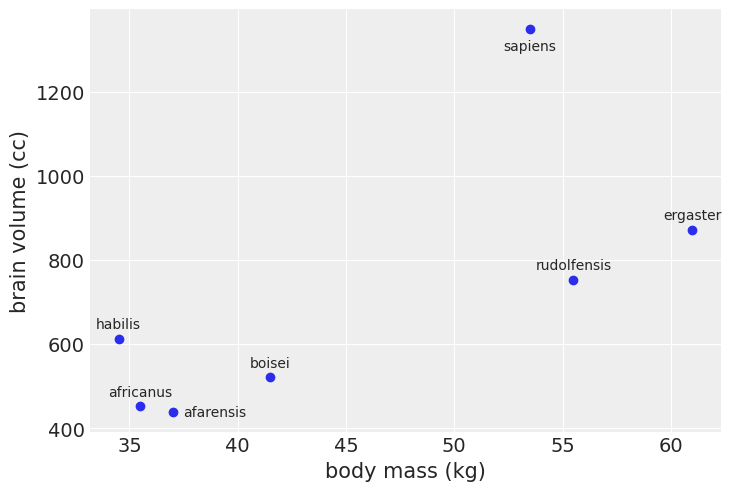

In [4]:
# Figure 7.2

plt.scatter(brains.mass, brains.brain)

# point labels
for i, r in brains.iterrows():
    if r.species == "afarensis":
        plt.text(r.mass + 0.5, r.brain, r.species, ha="left", va="center")
    elif r.species == "sapiens":
        plt.text(r.mass, r.brain - 25, r.species, ha="center", va="top")
    else:
        plt.text(r.mass, r.brain + 25, r.species, ha="center")

plt.xlabel("body mass (kg)")
plt.ylabel("brain volume (cc)");

#### Code 7.2

In [5]:
brains.loc[:, "mass_std"] = (brains.loc[:, "mass"] - brains.loc[:, "mass"].mean()) / brains.loc[
    :, "mass"
].std()
brains.loc[:, "brain_std"] = brains.loc[:, "brain"] / brains.loc[:, "brain"].max()

#### Code 7.3

This is modified from [Chapter 6 of 1st Edition](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb) (6.2 - 6.6).

In [6]:
m_7_1 = smf.ols("brain_std ~ mass_std", data=brains).fit()
m_7_1.summary()

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Sat, 06 Jan 2024   Prob (F-statistic):             0.0798
Time:                        18:16:27   Log-Likelihood:                 2.9925
No. Observations:                   7   AIC:                            -1.985
Df Residuals:                       5   BIC:                            -2.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5287      0.071      7.492      0.001       0.347       0.710
mass_std       0.1671      0.076      2.192      0.080      -0.029       0.363
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Code 7.4

In [7]:
p, cov = np.polyfit(brains.loc[:, "mass_std"], brains.loc[:, "brain_std"], 1, cov=True)

post = stats.multivariate_normal(p, cov).rvs(1000)

az.summary({k: v for k, v in zip("ba", post.T)}, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
b,0.169,0.074,0.058,0.294
a,0.528,0.069,0.410,0.634


#### Code 7.5

In [8]:
1 - m_7_1.resid.var() / brains.brain_std.var()

0.49015804794908413

#### Code 7.6

In [9]:
def R2_is_bad(model):
    return 1 - model.resid.var() / brains.brain_std.var()


R2_is_bad(m_7_1)

0.49015804794908413

#### Code 7.7

In [10]:
m_7_2 = smf.ols("brain_std ~ mass_std + I(mass_std**2)", data=brains).fit()
m_7_2.summary()

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     2.310
Date:                Sat, 06 Jan 2024   Prob (F-statistic):              0.215
Time:                        18:16:27   Log-Likelihood:                 3.3223
No. Observations:                   7   AIC:                           -0.6445
Df Residuals:                       4   BIC:                           -0.8068
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6142      0.155      3.950      0.017       0.182       1.046
mass_std             0.1957      0.093      2.101      0.104      -0.063       0.454
I(mass_std ** 2)    -0.0998      0.159     -0.629      0.564      -0.540       0.341
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.479
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.016
Skew:                           0.901   Prob(JB):                        0.602
Kurtosis:                       2.514   Cond. No.                         4.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Code 7.8

In [11]:
m_7_3 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)", data=brains).fit()
m_7_4 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4)",
    data=brains,
).fit()
m_7_5 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5)",
    data=brains,
).fit()

#### Code 7.9

In [12]:
m_7_6 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5) + I(mass_std**6)",
    data=brains,
).fit()

#### Code 7.10

The chapter gives code to produce the first panel of Figure 7.3. Here, produce the entire figure by looping over models 7.1-7.6.

To sample the posterior predictive on a new independent variable we make use of theano SharedVariable objects, as outlined [here](https://docs.pymc.io/notebooks/data_container.html)

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


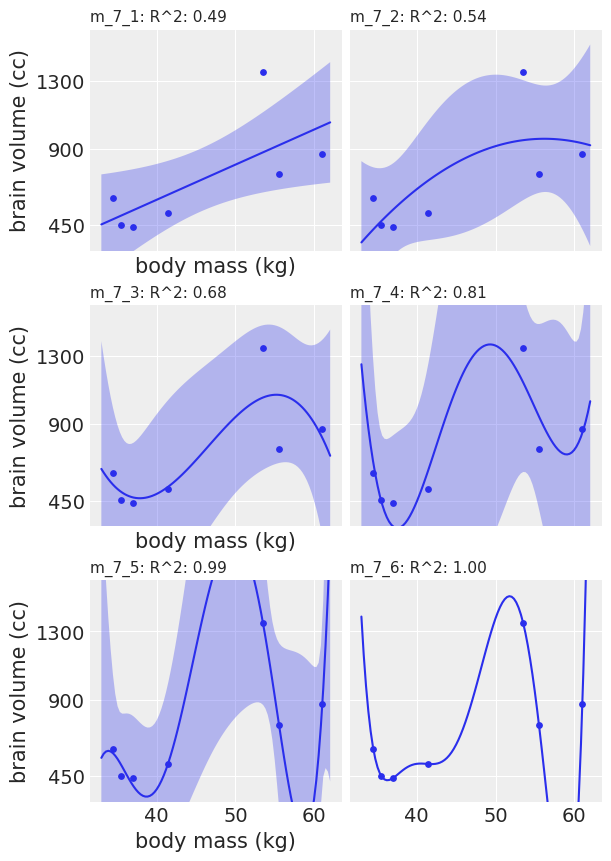

In [13]:
models = [m_7_1, m_7_2, m_7_3, m_7_4, m_7_5, m_7_6]
names = ["m_7_1", "m_7_2", "m_7_3", "m_7_4", "m_7_5", "m_7_6"]

mass_plot = np.linspace(33, 62, 100)
mass_new = (mass_plot - brains.mass.mean()) / brains.mass.std()

fig, axs = plt.subplots(3, 2, figsize=[6, 8.5], sharex=True, sharey="row")

for model, name, ax in zip(models, names, axs.flat):
    prediction = model.get_prediction({"mass_std": mass_new})
    pred = prediction.summary_frame(alpha=0.11) * brains.brain.max()

    ax.plot(mass_plot, pred["mean"])
    ax.fill_between(mass_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.3)
    ax.scatter(brains.mass, brains.brain, color="C0", s=15)

    ax.set_title(f"{name}: R^2: {model.rsquared:.2f}", loc="left", fontsize=11)

    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("brain volume (cc)")

    if ax.get_subplotspec().is_first_col():
        ax.set_xlabel("body mass (kg)")

    if ax.get_subplotspec().is_first_col():
        ax.set_ylim(-500, 2100)
        ax.axhline(0, ls="dashed", c="k", lw=1)
        ax.set_yticks([0, 450, 1300])
    else:
        ax.set_ylim(300, 1600)
        ax.set_yticks([450, 900, 1300])

#### Code 7.11 - this is R specific notation for dropping rows

In [14]:
brains_new = brains.drop(brains.index[-1])

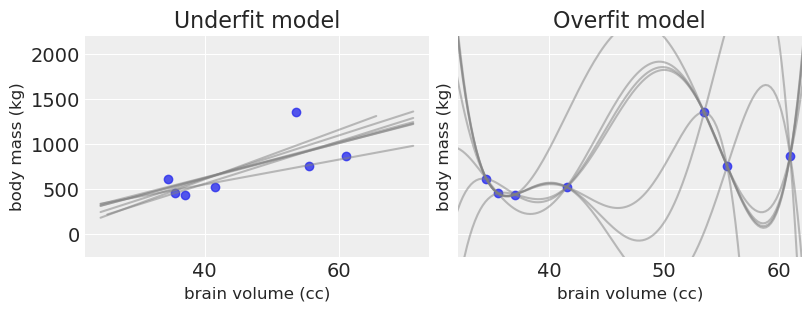

In [15]:
# Figure 7.4

# this code taken from PyMC port of Rethinking/Chp_06.ipynb

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 3))
ax1.scatter(brains.mass, brains.brain, alpha=0.8)
ax2.scatter(brains.mass, brains.brain, alpha=0.8)
for i in range(len(brains)):
    d_new = brains.drop(brains.index[-i])  # drop each data point in turn

    # first order model
    m0 = smf.ols("brain ~ mass", d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame(
        {"mass": np.linspace(x.mass.min() - 10, x.mass.max() + 10, 50)}
    )  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, "gray", alpha=0.5)
    ax1.set_ylabel("body mass (kg)", fontsize=12)
    ax1.set_xlabel("brain volume (cc)", fontsize=12)
    ax1.set_title("Underfit model")

    # fifth order model
    m1 = smf.ols(
        "brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)", data=d_new
    ).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame(
        {"mass": np.linspace(x.mass.min() - 10, x.mass.max() + 10, 200)}
    )  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, "gray", alpha=0.5)
    ax2.set_xlim(32, 62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel("body mass (kg)", fontsize=12)
    ax2.set_xlabel("brain volume (cc)", fontsize=12)
    ax2.set_title("Overfit model")

#### Code 7.12

In [16]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

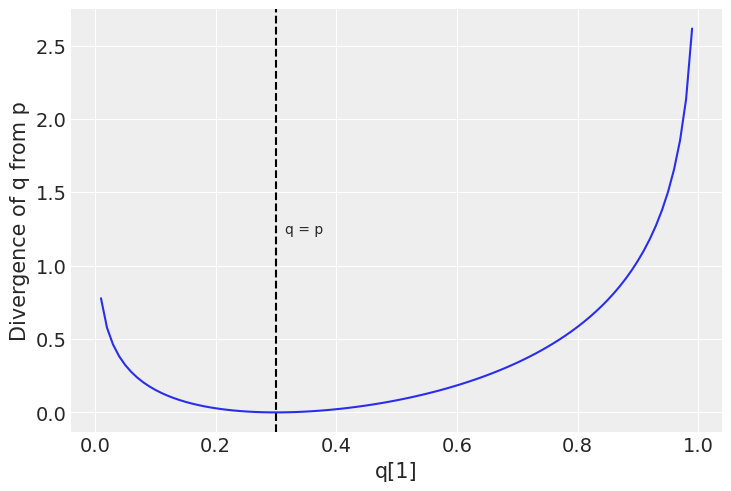

In [17]:
# Figure 7.5
p = np.array([0.3, 0.7])
q = np.arange(0.01, 1, 0.01)
DKL = np.sum(p * np.log(p / np.array([q, 1 - q]).T), 1)

plt.plot(q, DKL)
plt.xlabel("q[1]")
plt.ylabel("Divergence of q from p")
plt.axvline(0.3, ls="dashed", color="k")
plt.text(0.315, 1.22, "q = p");

#### Code 7.13 & 7.14

In [18]:
n_samples = 3000

intercept, slope = stats.multivariate_normal(m_7_1.params, m_7_1.cov_params()).rvs(n_samples).T

pred = intercept + slope * brains.mass_std.values.reshape(-1, 1)

n, ns = pred.shape

In [19]:
# PyMC does not have a way to calculate LPPD directly, so we use the approach from 7.14

sigmas = (np.sum((pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
ll = np.zeros((n, ns))
for s in range(ns):
    logprob = stats.norm.logpdf(brains.brain_std, pred[:, s], sigmas[s])
    ll[:, s] = logprob

lppd = np.zeros(n)
for i in range(n):
    lppd[i] = logsumexp(ll[i]) - np.log(ns)

lppd

array([ 0.62060273,  0.66080837,  0.56608632,  0.62876608,  0.47909493,
        0.44851465, -0.8559313 ])

#### Code 7.15

In [20]:
# make an lppd function that can be applied to all models (from code above)
def lppd(model, n_samples=1e4):
    n_samples = int(n_samples)

    pars = stats.multivariate_normal(model.params, model.cov_params()).rvs(n_samples).T
    dmat = dmatrix(
        model.model.data.design_info, brains, return_type="dataframe"
    ).values  # get model design matrix
    pred = dmat.dot(pars)

    n, ns = pred.shape

    # this approach for calculating lppd isfrom 7.14
    sigmas = (np.sum((pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
    ll = np.zeros((n, ns))
    for s in range(ns):
        logprob = stats.norm.logpdf(brains.brain_std, pred[:, s], sigmas[s])
        ll[:, s] = logprob

    lppd = np.zeros(n)
    for i in range(n):
        lppd[i] = logsumexp(ll[i]) - np.log(ns)

    return lppd

In [21]:
# model 7_6 does not work with OLS because its covariance matrix is not finite.
lppds = np.array(list(map(lppd, models[:-1], [1000] * len(models[:-1]))))

lppds.sum(1)

array([ 2.54799078,  2.3115561 ,  2.89843278,  3.53621752, 11.04367575])

#### Code 7.16

This relies on the `sim.train.test` function in the `rethinking` package. [This](https://github.com/rmcelreath/rethinking/blob/master/R/sim_train_test.R) is the original function.

The python port of this function below is from [Rethinking/Chp_06](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb) Code 6.12.

In [22]:
def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100, samples=1000):

    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]

    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

    mm_train = np.ones((N, 1))

    np.concatenate([mm_train, x_train[:, 1:k]], axis=1)

    # Using pymc
    with pm.Model() as m_sim:
        vec_V = pm.MvNormal(
            "vec_V",
            mu=0,
            cov=b_sigma * np.eye(n_dim),
            shape=(1, n_dim),
            initval=np.random.randn(1, n_dim) * 0.01,
        )
        mu = pm.Deterministic("mu", 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal("y", mu=mu, sigma=1, observed=x_train[:, 0].reshape(-1, 1))

    with m_sim:
        idata_sim = pm.sample(samples, progressbar=False)

    vec = az.summary(idata_sim)["mean"][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)

    dev_train = -2 * sum(stats.norm.logpdf(x_train, loc=np.matmul(x_train, vec), scale=1))

    mm_test = np.ones((N, 1))

    mm_test = np.concatenate([mm_test, x_test[:, 1 : k + 1]], axis=1)

    dev_test = -2 * sum(stats.norm.logpdf(x_test[:, 0], loc=np.matmul(mm_test, vec), scale=1))

    return np.mean(dev_train), np.mean(dev_test)

In [23]:
# This cell is expected have a long run time
n = 20
tries = 10
param = 6
r = np.zeros(shape=(param - 1, 4))

train = []
test = []

# setting log output to error
logger = logging.getLogger("pymc")
init_level = logger.level
logger.setLevel(logging.ERROR)

for j in range(2, param + 1):
    print(f"Num Params: {j}")
    for i in tqdm.tqdm(range(1, tries + 1)):
        tr, te = sim_train_test(N=n, k=param, samples=1000)
        train.append(tr), test.append(te)
    r[j - 2, :] = (
        np.mean(train),
        np.std(train, ddof=1),
        np.mean(test),
        np.std(test, ddof=1),
    )

# resetting logger level
logger.setLevel(init_level)

Num Params: 2


100%|██████████| 10/10 [11:12<00:00, 67.29s/it]


Num Params: 3


100%|██████████| 10/10 [10:42<00:00, 64.20s/it]


Num Params: 4


100%|██████████| 10/10 [12:18<00:00, 73.88s/it]


Num Params: 5


100%|██████████| 10/10 [08:22<00:00, 50.22s/it]


Num Params: 6


100%|██████████| 10/10 [06:08<00:00, 36.80s/it]


#### Code 7.17

Does not apply because multi-threading is automatic in PyMC.

#### Code 7.18

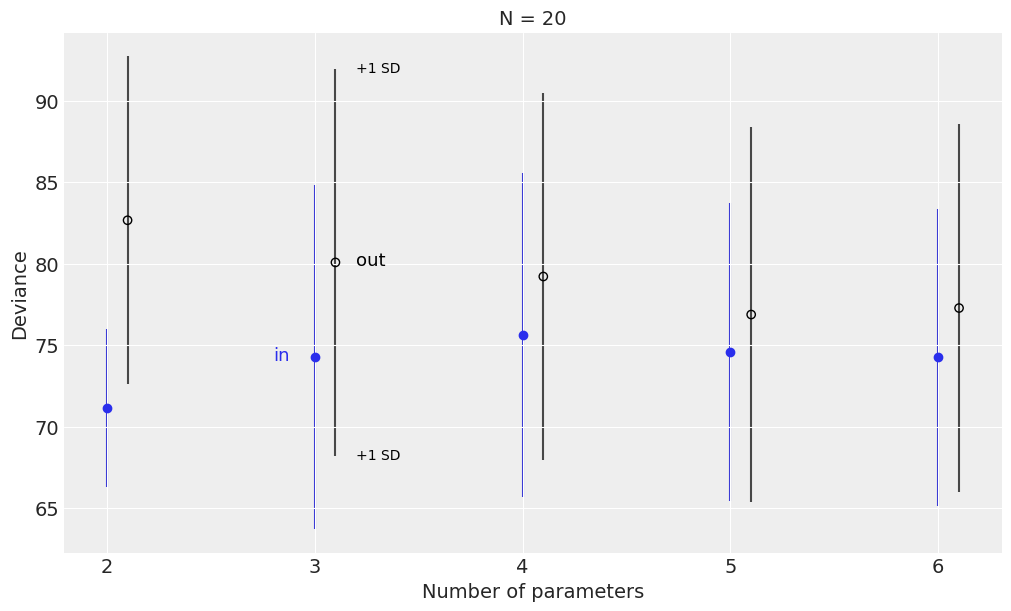

In [24]:
num_param = np.arange(2, param + 1)

plt.figure(figsize=(10, 6))
plt.scatter(num_param, r[:, 0], color="C0")
plt.xticks(num_param)

for j in range(param - 1):
    plt.vlines(
        num_param[j],
        r[j, 0] - r[j, 1],
        r[j, 0] + r[j, 1],
        color="mediumblue",
        zorder=-1,
        alpha=0.80,
    )

plt.scatter(num_param + 0.1, r[:, 2], facecolors="none", edgecolors="k")

for j in range(param - 1):
    plt.vlines(
        num_param[j] + 0.1,
        r[j, 2] - r[j, 3],
        r[j, 2] + r[j, 3],
        color="k",
        zorder=-2,
        alpha=0.70,
    )

dist = 0.20
plt.text(num_param[1] - dist, r[1, 0] - dist, "in", color="C0", fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] - dist, "out", color="k", fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] + r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
plt.text(num_param[1] + dist, r[1, 2] - r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
plt.xlabel("Number of parameters", fontsize=14)
plt.ylabel("Deviance", fontsize=14)
plt.title(f"N = {n}", fontsize=14)
plt.show()

These uncertainties are a *lot* larger than in the book... MCMC vs OLS again?

#### Code 7.19

7.19 to 7.25 transcribed directly from 6.15-6.20 in [Chapter 6 of 1st Edition](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb).

In [25]:
data = pd.read_csv("Data/cars.csv", sep=",", index_col=0)

In [26]:
with pm.Model() as m:
    a = pm.Normal("a", mu=0, sigma=100)
    b = pm.Normal("b", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", 0, 30)
    mu = pm.Deterministic("mu", a + b * data["speed"].values)
    dist = pm.Normal("dist", mu=mu, sigma=sigma, observed=data["dist"].values)
    idata = pm.sample(5000, tune=10000)

post = az.extract(idata, group="posterior")
post = post.sel(draw=slice(None, None, int(len(post["sample"]) / 1000)))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 70 seconds.


#### Code 7.20

In [27]:
n_samples = 1000
n_cases = data.shape[0]
logprob = np.zeros((n_cases, n_samples))

for s in range(0, n_samples):
    mu = post["a"][s].values + post["b"][s].values * data["speed"].values
    p_ = stats.norm.logpdf(data["dist"], loc=mu, scale=post["sigma"][s])
    logprob[:, s] = p_

#### Code 7.21

In [28]:
n_cases = data.shape[0]
lppd = np.zeros(n_cases)
for a in range(1, n_cases):
    lppd[a] = logsumexp(logprob[a]) - np.log(n_samples)

#### Code 7.22

In [29]:
pWAIC = np.zeros(n_cases)
for i in range(1, n_cases):
    pWAIC[i] = np.var(logprob[i])

#### Code 7.23

In [30]:
-2 * (sum(lppd) - sum(pWAIC))

412.4821183915903

#### Code 7.24

In [31]:
waic_vec = -2 * (lppd - pWAIC)
(n_cases * np.var(waic_vec)) ** 0.5

15.166401252547269

#### Setup for Code 7.25+

Have to reproduce m6.6-m6.8 from Code 6.13-6.17 in Chapter 6

In [34]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)

    mu = pm.Deterministic("mu", p * d.h0.values)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    idata_6_6 = pm.sample(idata_kwargs={"log_likelihood": True})

with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment.values + bf * d.fungus.values

    mu = pm.Deterministic("mu", p * d.h0.values)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    idata_6_7 = pm.sample(idata_kwargs={"log_likelihood": True})

with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment.values

    mu = pm.Deterministic("mu", p * d.h0.values)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    idata_6_8 = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 125 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, bf, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


#### Code 7.25

In [35]:
az.waic(idata_6_7, m_6_7, scale="deviance")

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

              Estimate       SE
deviance_waic   354.19    16.44
p_waic            3.80        -

There has been a warning during the calculation. Please check the results.

#### Code 7.26

In [36]:
compare_df = az.compare(
    {
        "m_6_6": idata_6_6,
        "m_6_7": idata_6_7,
        "m_6_8": idata_6_8,
    },
    method="pseudo-BMA",
    ic="waic",
    scale="deviance",
)
compare_df

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:308: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weight = weights[idx]
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please ex

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m_6_7,0,354.186337,3.795880,0.000000,1.000000e+00,16.435724,0.000000,True,deviance
m_6_8,1,396.081837,2.585063,41.895500,7.989282e-10,11.801564,10.355626,False,deviance
m_6_6,2,405.033962,1.541091,50.847624,9.090310e-12,11.304391,14.164343,False,deviance


#### Code 7.27

In [37]:
waic_m_6_7 = az.waic(idata_6_7, pointwise=True, scale="deviance")
waic_m_6_8 = az.waic(idata_6_8, pointwise=True, scale="deviance")

# pointwise values are stored in the waic_i attribute.
diff_m_6_7_m_6_8 = waic_m_6_7.waic_i - waic_m_6_8.waic_i

n = len(diff_m_6_7_m_6_8)

np.sqrt(n * np.var(diff_m_6_7_m_6_8)).values

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


array(10.35562563)

#### Code 7.28

In [38]:
40.0 + np.array([-1, 1]) * 10.4 * 2.6

array([12.96, 67.04])

#### Code 7.29

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\plots\backends\matplotlib\compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


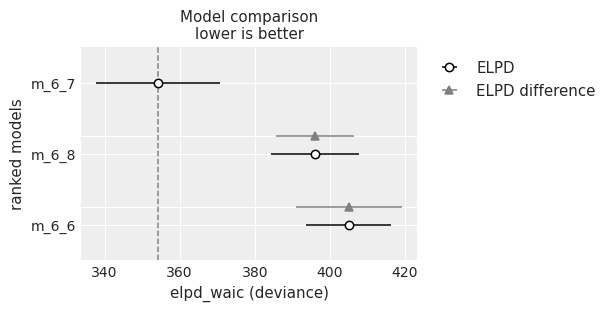

In [39]:
az.plot_compare(compare_df);

#### Code 7.30

In [40]:
waic_m_6_6 = az.waic(idata_6_6, pointwise=True, scale="deviance")

diff_m6_6_m6_8 = waic_m_6_6.waic_i - waic_m_6_8.waic_i

n = len(diff_m6_6_m6_8)

np.sqrt(n * np.var(diff_m6_6_m6_8)).values

array(7.65519951)

#### Code 7.31

dSE is calculated by compare above, but `rethinking` produces a pairwise comparison. This is not implemented in `arviz`, but we can hack it together:

In [41]:
dataset_dict = {"m_6_6": idata_6_6, "m_6_7": idata_6_7, "m_6_8": idata_6_8}

# compare all models
s0 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]
# the output compares each model to the 'best' model - i.e. two models are compared to one.
# to complete a pair-wise comparison we need to compare the remaining two models.

# to do this, remove the 'best' model from the input data
del dataset_dict[s0.index[0]]

# re-run compare with the remaining two models
s1 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]

# s0 compares two models to one model, and s1 compares the remaining two models to each other
# now we just nee to wrangle them together!

# convert them both to dataframes, setting the name to the 'best' model in each `compare` output.
# (i.e. the name is the model that others are compared to)
df_0 = s0.to_frame(name=s0.index[0])
df_1 = s1.to_frame(name=s1.index[0])

# merge these dataframes to create a pairwise comparison
pd.merge(df_0, df_1, left_index=True, right_index=True)

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'deviance' has dtype incompatible with float64, please explicitly cast to

,m_6_7,m_6_8
m_6_8,10.355626,0.0000
m_6_6,14.164343,7.6552


**Note:** this work for three models, but will get increasingly hack-y with additional models. The function below can be applied to *n* models:

In [42]:
def pairwise_compare(dataset_dict, metric="dse", **kwargs):
    """
    Calculate pairwise comparison of models in dataset_dict.

    Parameters
    ----------
    dataset_dict : dict
        A dict containing two ore more {'name': pymc.backends.base.MultiTrace}
        items.
    metric : str
        The name of the matric to be calculated. Can be any valid column output
        by `arviz.compare`. Note that this may change depending on the **kwargs
        that are specified.
    kwargs
        Arguments passed to `arviz.compare`
    """
    data_dict = dataset_dict.copy()
    dicts = []

    while len(data_dict) > 1:
        c = az.compare(data_dict, **kwargs)[metric]
        dicts.append(c.to_frame(name=c.index[0]))
        del data_dict[c.index[0]]

    return pd.concat(dicts, axis=1)

In [43]:
dataset_dict = {"m_6_6": idata_6_6, "m_6_7": idata_6_7, "m_6_8": idata_6_8}

pairwise_compare(dataset_dict, metric="dse", ic="waic", scale="deviance")

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'deviance' has dtype incompatible with float64, please explicitly cast to

,m_6_7,m_6_8
m_6_7,0.000000,NaN
m_6_8,10.355626,0.0000
m_6_6,14.164343,7.6552


#### Code 7.32

In [44]:
d = pd.read_csv("Data/WaffleDivorce.csv", delimiter=";")

d["A"] = stats.zscore(d["MedianAgeMarriage"])
d["D"] = stats.zscore(d["Divorce"])
d["M"] = stats.zscore(d["Marriage"])

In [45]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)

    mu = a + bA * d["A"].values
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"].values)

    idata_5_1 = pm.sample(idata_kwargs={"log_likelihood": True})

with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bM * d["M"].values
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"].values)

    idata_5_2 = pm.sample(idata_kwargs={"log_likelihood": True})

with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"].values + bM * d["M"].values
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"].values)

    idata_5_3 = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


#### Code 7.33

In [46]:
az.compare(
    {"m_5_1": idata_5_1, "m_5_2": idata_5_2, "m_5_3": idata_5_3},
    scale="deviance",
)

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:309: FutureWarning: Setting

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m_5_1,0,126.744583,3.633233,0.000000,8.952877e-01,12.752294,0.000000,False,deviance
m_5_3,1,128.781328,4.875825,2.036744,6.869485e-15,12.853132,0.782898,False,deviance
m_5_2,2,140.367350,2.968821,13.622767,1.047123e-01,9.870875,9.262995,True,deviance


#### Code 7.34

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


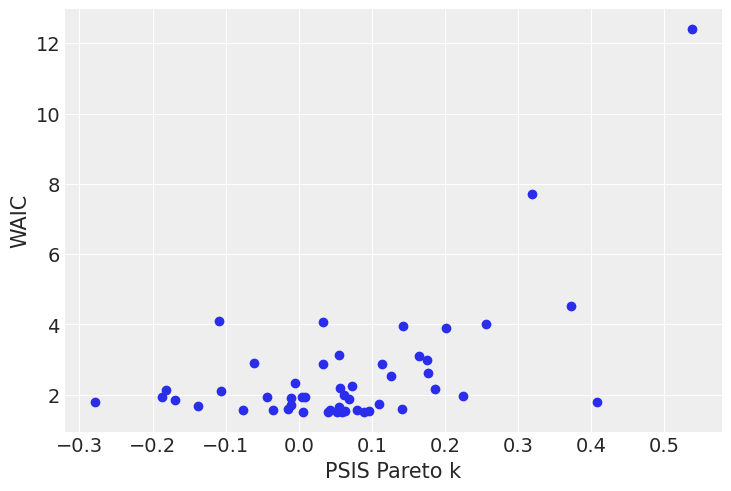

In [47]:
psis_m_5_3 = az.loo(idata_5_3, pointwise=True, scale="deviance")
waic_m_5_3 = az.waic(idata_5_3, pointwise=True, scale="deviance")

# Figure 7.10
plt.scatter(psis_m_5_3.pareto_k, waic_m_5_3.waic_i)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC");

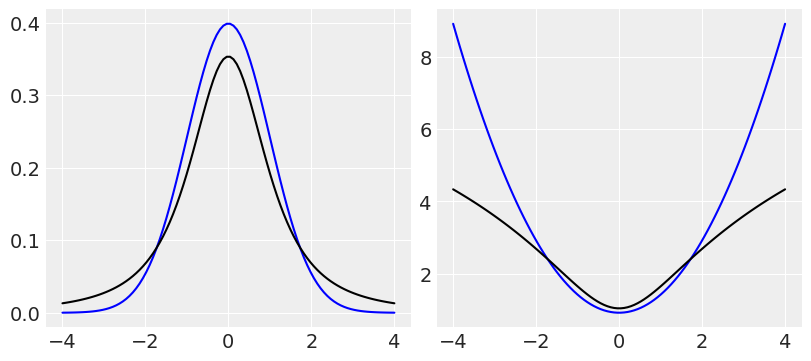

In [48]:
# Figure 7.11
v = np.linspace(-4, 4, 100)

g = stats.norm(loc=0, scale=1)
t = stats.t(df=2, loc=0, scale=1)

fig, (ax, lax) = plt.subplots(1, 2, figsize=[8, 3.5])

ax.plot(v, g.pdf(v), color="b")
ax.plot(v, t.pdf(v), color="k")

lax.plot(v, -g.logpdf(v), color="b")
lax.plot(v, -t.logpdf(v), color="k");

#### Code 7.35

In [49]:
with pm.Model() as m_5_3t:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"].values + bM * d["M"].values
    sigma = pm.Exponential("sigma", 1)

    D = pm.StudentT("D", nu=2, mu=mu, sigma=sigma, observed=d["D"].values)

    idata_5_3t = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [50]:
az.loo(idata_5_3t, pointwise=True, scale="deviance")

Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

             Estimate       SE
deviance_loo   133.85    11.41
p_loo            6.11        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

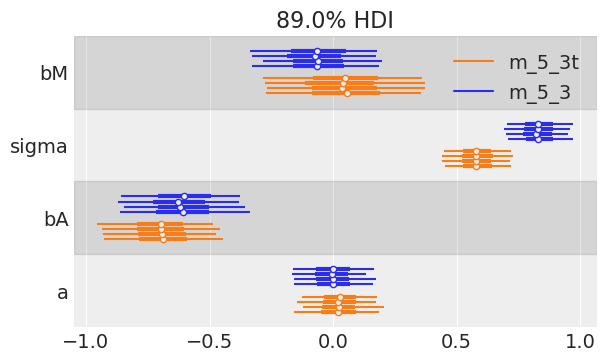

In [51]:
az.plot_forest([idata_5_3, idata_5_3t], model_names=["m_5_3", "m_5_3t"], figsize=[6, 3.5]);

In [52]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Jan 06 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

pymc       : 5.10.3
tqdm       : 4.65.0
matplotlib : 3.8.2
numpy      : 1.26.3
pandas     : 2.1.4
statsmodels: 0.14.0
scipy      : 1.11.4
arviz      : 0.17.0
logging    : 0.5.1.2

Watermark: 2.4.3

